# Here we build our dictionary and train our model

Using the candidates and parties preprocessed tweets as our labeled dataset

In [1]:
# Libs
import csv
import string
import numpy as np
import time
import sys
import nltk
import random
import matplotlib.pyplot as plt
from joblib import dump, load

from tqdm import tqdm_notebook as tqdm

from nltk.tokenize import word_tokenize

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import libs.bag_of_worder as bag_of_worder
import libs.preprocessor as tweet_preproc

# Init Preprocessor
twitterPreprocessor = tweet_preproc.TwitterPreprocessor()

# Dataset

IMPORTANT, the label should have only two states 0: dems, 1: republican

In [4]:
def load_dataset(path):
    
    x = []
    y = []

    with open(path, 'r', newline='', encoding="utf-8") as csvfile:
        
        reader = csv.reader(csvfile, quotechar='"', delimiter=',')
        
        # Taking the header of the file + the index of useful columns:
        header = next(reader)
        ind_label = header.index('label')
        ind_text = header.index('text')
        
        for row in reader:
            
            label = row[ind_label]
            if label == "democrat":
                y.append(0)
            elif label == "republican":
                y.append(1)
            else:
                continue
                
            x.append(row[ind_text])
            

        assert len(x) == len(y)

        return x, y

In [5]:
def checkBalanced(labels):
    return np.count_nonzero(labels)/len(labels)


def balance_dataset(features, labels):
    
    # Combine the features with the labels
    combined = list(zip(features, labels))
    
    # Shuffle the list
    random.shuffle(combined)

    # Split the feature and label
    X[:], y[:] = zip(*combined)
    
    # Count number of '1'
    nbrOfOnes = np.count_nonzero(y)
    nbrOfZeros = len(y) - nbrOfOnes
    excessNbr = abs(nbrOfOnes - nbrOfZeros)
    
    # Balance dataset
    removed_counter = 0
    if(nbrOfOnes > nbrOfZeros):  # too much '1'

        for ind in range(0,len(y)):
            if(y[ind] == 1):
                X.pop(ind)
                y.pop(ind)
                removed_counter = removed_counter + 1
                
            if(removed_counter >= abs(excessNbr)):
                break

    else:                       # too much '0'

        for ind in range(0,len(y)):
            if(y[ind] == 0):
                X.pop(ind)
                y.pop(ind)
                removed_counter = removed_counter + 1
                
            if(removed_counter >= abs(excessNbr)):
                break
            
    return X, y

In [6]:
# Path of the labeled dataset
path = "data/parties_candidates/sources.csv"

# Load dataset from path
X, y = load_dataset(path)

# Make sure there is 50/50 of both labels
X, y = balance_dataset(X,y)

# Split the data
train_X, valid_X, train_Y, valid_Y = train_test_split(X, y, test_size=0.2, random_state=12, shuffle=True, stratify=y)

print("Length of training set : ", len(train_X))
print("Length of validation set : ", len(valid_X))

Length of training set :  93948
Length of validation set :  23488


In [7]:
# Make sure the training data is balanced
print("--- Proportion of republican label ---")
print(checkBalanced(train_Y))

--- Proportion of republican label ---
0.5


# Review Length in Words
Inspired from: https://machinelearningmastery.com/predict-sentiment-movie-reviews-using-deep-learning/

In [8]:
# Summarize number of classes
print("Classes: ")
print(np.unique(train_Y))

Classes: 
[0 1]


In [9]:
# Summarize number of words
print("Number of words: ")
print(len(np.unique(np.hstack(train_X))))

Number of words: 
66573


Review length: 
Mean 73.89 words (24.956086)


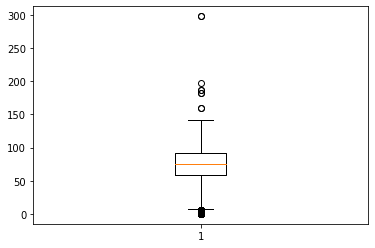

In [10]:
# Summarize review length
print("Review length: ")
result = [len(x) for x in train_X]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))
# plot review length
fig = plt.figure()
plt.boxplot(result)
plt.show()

## Training and testing models
Codes copied from: https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/

### Transforming data

In [12]:
top_words = 5000

In [13]:
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(train_X)

train_X_t = tokenizer.texts_to_sequences(train_X)
valid_X_t = tokenizer.texts_to_sequences(valid_X)

In [14]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 220

train_X_t = pad_sequences(train_X_t, padding='post', maxlen=maxlen)
valid_X_t = pad_sequences(valid_X_t, padding='post', maxlen=maxlen)

print('vocab_size: {}'.format(vocab_size))

vocab_size: 43487


In [15]:
train_X_t[3]

array([  58,   96,  988,   63,   92,   26, 3681,  150,  505, 4137,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

Lets save our tokenizer

In [16]:
# saving
with open('model/tokenizer.joblib', 'wb') as handle:
    dump(tokenizer, handle) 

### Random Forest algorithm
Here, we don't need any normalization.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(train_X_t, train_Y)

In [ ]:
predictions = text_classifier.predict(valid_X_t)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(valid_Y, predictions))
print(classification_report(valid_Y, predictions))
print(accuracy_score(valid_Y, predictions))

In [ ]:
# saving
with open('model/rand_forest.joblib', 'wb') as handle:
    dump(text_classifier, handle) 

### Logistic Regression algorithm

In [23]:
from sklearn.preprocessing import MinMaxScaler
# Normalize data
scaler = MinMaxScaler()
train_X_t_n = scaler.fit_transform(train_X_t)
valid_X_t_n = scaler.transform(valid_X_t)

In [ ]:
from sklearn.linear_model import LogisticRegression

text_classifier = LogisticRegression()
text_classifier.fit(train_X_t, train_Y)

In [ ]:
predictions = text_classifier.predict(valid_X_t)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(valid_Y, predictions))
print(classification_report(valid_Y, predictions))
print(accuracy_score(valid_Y, predictions))

In [ ]:
# saving
with open('model/logistic.joblib', 'wb') as handle:
    dump(text_classifier, handle) 

### SVM algorithm

In [ ]:
from sklearn import svm

text_classifier = svm.SVC(gamma='auto')
text_classifier.fit(train_X_t_n, train_Y)

In [ ]:
predictions = text_classifier.predict(valid_X_t_n)

In [ ]:
print(confusion_matrix(valid_Y, predictions))
print(classification_report(valid_Y, predictions))
print(accuracy_score(valid_Y, predictions))

In [ ]:
dump(text_classifier, 'model/svm_svc.joblib')

### Simple Neural Network
Inspired from: https://machinelearningmastery.com/predict-sentiment-movie-reviews-using-deep-learning/

In [17]:
# create the model
model = Sequential()
model.add(Embedding(top_words, 32, input_length=maxlen))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 220, 32)           160000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 7040)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               1760250   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 251       
Total params: 1,920,501
Trainable params: 1,920,501
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
history = model.fit(train_X_t, train_Y, batch_size=128, epochs=5, verbose=2, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 75158 samples, validate on 18790 samples
Epoch 1/5
 - 26s - loss: 0.3480 - acc: 0.8345 - val_loss: 0.2483 - val_acc: 0.8943
Epoch 2/5
 - 31s - loss: 0.1994 - acc: 0.9186 - val_loss: 0.2335 - val_acc: 0.9042
Epoch 3/5
 - 29s - loss: 0.1405 - acc: 0.9453 - val_loss: 0.2295 - val_acc: 0.9135
Epoch 4/5
 - 27s - loss: 0.0934 - acc: 0.9658 - val_loss: 0.2518 - val_acc: 0.9173
Epoch 5/5
 - 29s - loss: 0.0651 - acc: 0.9766 - val_loss: 0.3011 - val_acc: 0.9162


In [19]:
model.save('model/dl_snn.h5')

In [20]:
score = model.evaluate(valid_X_t, valid_Y, verbose=0)

print('Test Score: {}'.format(score[0]))
print('Test Accuracy: {}'.format(score[1]))

Test Score: 0.31109315807212967
Test Accuracy: 0.9132322888283378


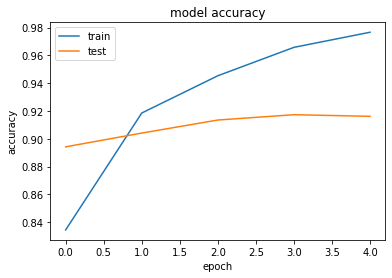

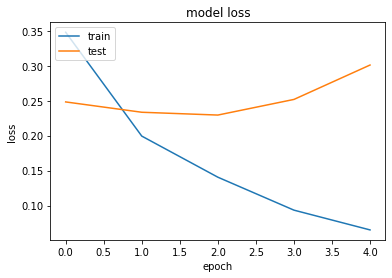

In [21]:
fig = plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(valid_X_t)

In [ ]:
print(confusion_matrix(valid_Y, predictions.round()))
print(classification_report(valid_Y, predictions.round()))
print(accuracy_score(valid_Y, predictions.round()))

### One-Dimensional Convolutional Neural Network Model
Inspired from: https://machinelearningmastery.com/predict-sentiment-movie-reviews-using-deep-learning/

In [ ]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [ ]:
# create the model
model = Sequential()
model.add(Embedding(top_words, 32, input_length=maxlen))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(train_X_t, train_Y, batch_size=128, epochs=5, verbose=2, validation_split=0.2)

In [ ]:
model.save('model/dl_cnn.h5')

In [ ]:
score = model.evaluate(valid_X_t, valid_Y, verbose=0)

print('Test Score: {}'.format(score[0]))
print('Test Accuracy: {}'.format(score[1]))

In [ ]:
fig = plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
fig.savefig('results/dl_cnn_train_curve_acc.pdf', bbox_inches='tight')

fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
fig.savefig('results/dl_cnn_train_curve_loss.pdf', bbox_inches='tight')

In [ ]:
predictions = model.predict(valid_X_t)

In [ ]:
print(confusion_matrix(valid_Y, predictions.round()))
print(classification_report(valid_Y, predictions.round()))
print(accuracy_score(valid_Y, predictions.round()))